In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("GPU DETECTED!")
else:
    print("No GPU found, using CPU")

TensorFlow version: 2.10.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU DETECTED!


### SETTING UP PATHS AND PARAMTERS

In [3]:
base_dir = 'chest_xray/chest_xray'

train_dir = base_dir + '/train'
test_dir  = base_dir + '/test'
val_dir   = base_dir + '/val'

IMG_HEIGHT = 150
IMG_WIDTH  = 150
BATCH_SIZE = 32
EPOCHS     = 10
class_names = ['NORMAL', 'PNEUMONIA']

In [4]:
train_normal    = len(os.listdir(train_dir + '/NORMAL'))
train_pneumonia = len(os.listdir(train_dir + '/PNEUMONIA'))
test_normal     = len(os.listdir(test_dir + '/NORMAL'))
test_pneumonia  = len(os.listdir(test_dir + '/PNEUMONIA'))
val_normal      = len(os.listdir(val_dir + '/NORMAL'))
val_pneumonia   = len(os.listdir(val_dir + '/PNEUMONIA'))

print("="*50)
print("CLASS DISTRIBUTION")
print("="*50)
print(f"\nTrain  - NORMAL: {train_normal},  PNEUMONIA: {train_pneumonia}")
print(f"Test   - NORMAL: {test_normal},   PNEUMONIA: {test_pneumonia}")
print(f"Val    - NORMAL: {val_normal},    PNEUMONIA: {val_pneumonia}")

CLASS DISTRIBUTION

Train  - NORMAL: 1342,  PNEUMONIA: 3876
Test   - NORMAL: 235,   PNEUMONIA: 390
Val    - NORMAL: 9,    PNEUMONIA: 9


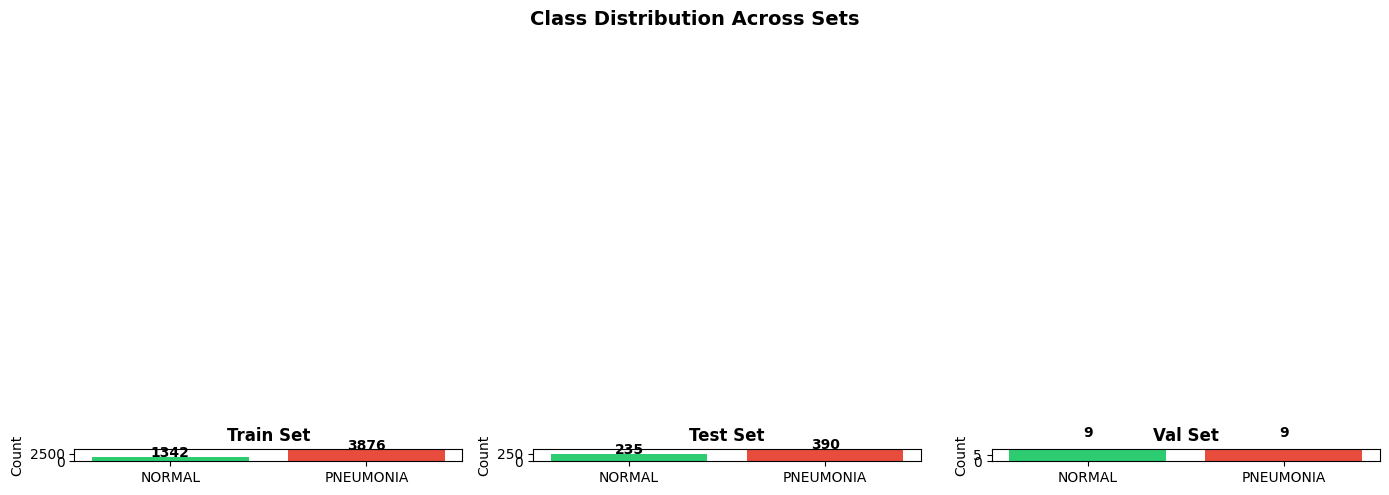

In [7]:
figs , axes = plt.subplots(1,3,figsize = (14,5))

sets = ['Train','Test','Val']
normals = [train_normal,test_normal,val_normal]
pneumos = [train_pneumonia,test_pneumonia,val_pneumonia]

for ax, s, n, p in zip(axes, sets, normals, pneumos):
    ax.bar(['NORMAL', 'PNEUMONIA'], [n, p], color=['#2ecc71', '#e74c3c'])
    ax.set_title(f'{s} Set', fontweight='bold')
    ax.set_ylabel('Count')
    for j, v in enumerate([n, p]):
        ax.text(j, v + 10, str(v), ha='center', fontweight='bold')

plt.suptitle('Class Distribution Across Sets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
    

### LOAD AND PREPROCESS IMAGES

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values to [0,1]
    rotation_range=15,        # data augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale=1./255)

In [10]:
# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 626 images belonging to 2 classes.


In [12]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 16 images belonging to 2 classes.


In [16]:
print("\nClass indices:", train_generator.class_indices)
print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples:       {test_generator.samples}")


Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples:   5216
Validation samples: 16
Test samples:       626


### VISUALIZE SAMPLE IMAGES

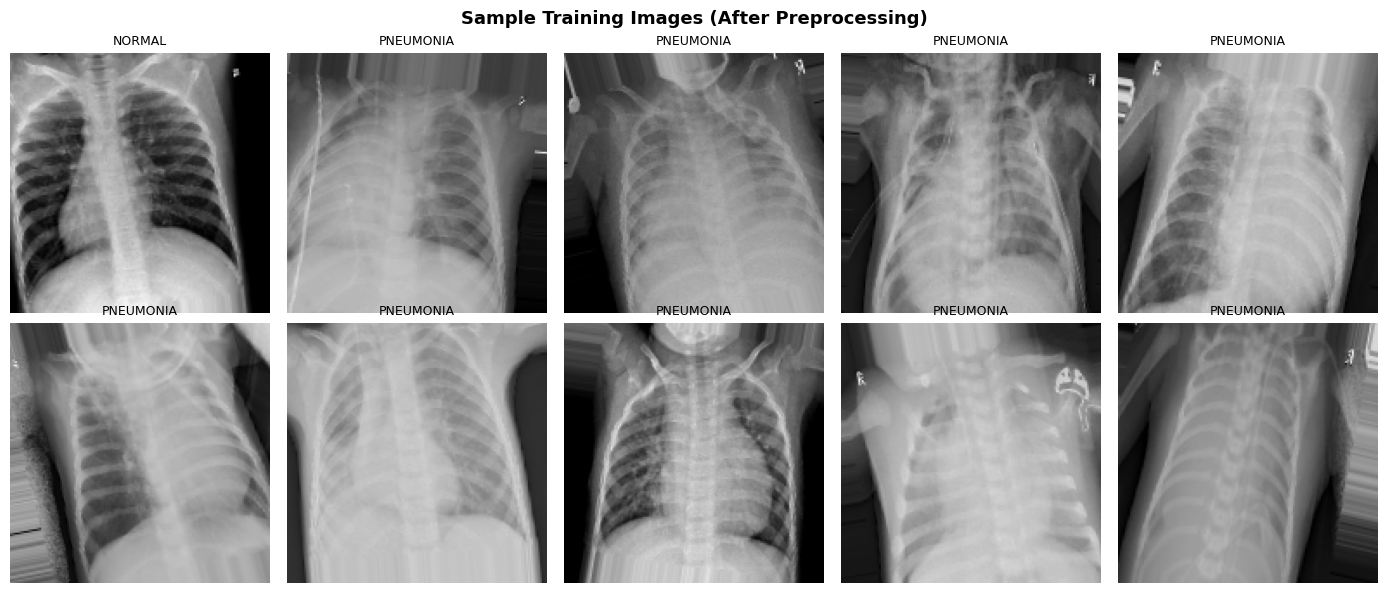

In [17]:
images, labels = next(train_generator)

plt.figure(figsize=(14, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis('off')
plt.suptitle('Sample Training Images (After Preprocessing)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### CNN Model

In [18]:
model = models.Sequential([

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Block 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel compiled!")


Model compiled!


### Train model

In [20]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

print("\nTraining complete!")

Epoch 1/10
163/163 [==============================] - 149s 856ms/step - loss: 0.5206 - accuracy: 0.7590 - val_loss: 0.5693 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 77s 470ms/step - loss: 0.3248 - accuracy: 0.8583 - val_loss: 0.6696 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 79s 483ms/step - loss: 0.2445 - accuracy: 0.9009 - val_loss: 0.7864 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 75s 456ms/step - loss: 0.2209 - accuracy: 0.9126 - val_loss: 0.4424 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 77s 473ms/step - loss: 0.1992 - accuracy: 0.9178 - val_loss: 0.6166 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 83s 512ms/step - loss: 0.1992 - accuracy: 0.9172 - val_loss: 0.5782 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 84s 515ms/step - loss: 0.1764 - accuracy: 0.9319 - val_loss: 0.5131 - val_a

### PLOT TRAINING HISTORY

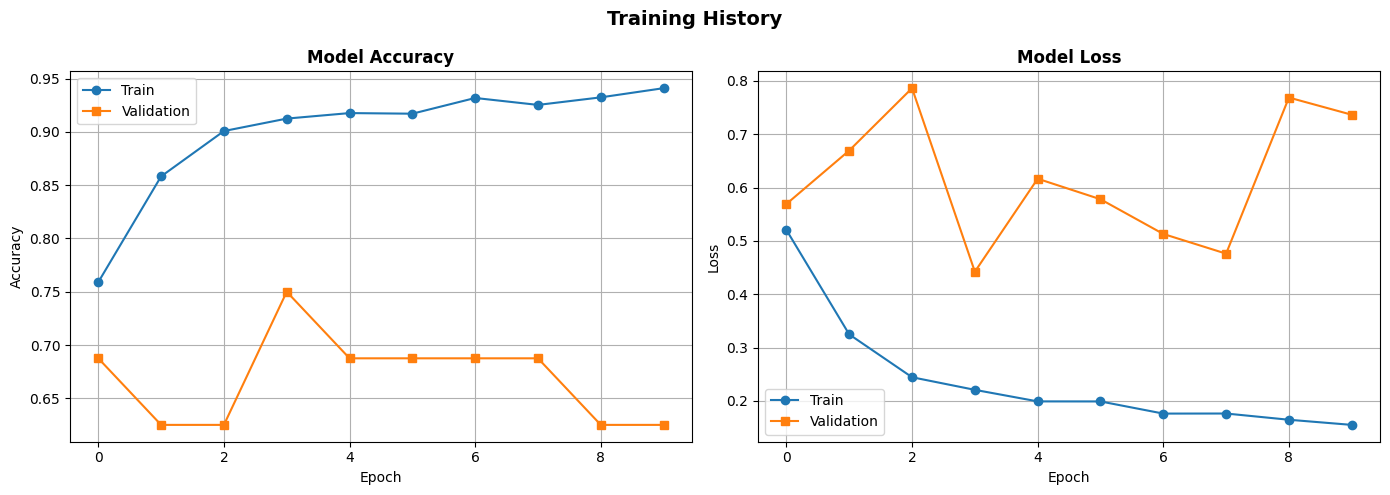

In [36]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation', marker='s')
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Loss plot
axes[1].plot(history.history['loss'], label='Train', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation', marker='s')
axes[1].set_title('Model Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### EVALUATE ON TEST SET

In [22]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 [==============================] - 17s 752ms/step - loss: 0.4504 - accuracy: 0.8147

Test Loss:     0.4504
Test Accuracy: 0.8147


### GENERATE PREDICTIONS

In [23]:
test_generator.reset()

y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

print(f"\nPredictions generated: {len(y_pred)}")


20/20 [==============================] - 6s 281ms/step

Predictions generated: 626


### CONFUSION MATRIX

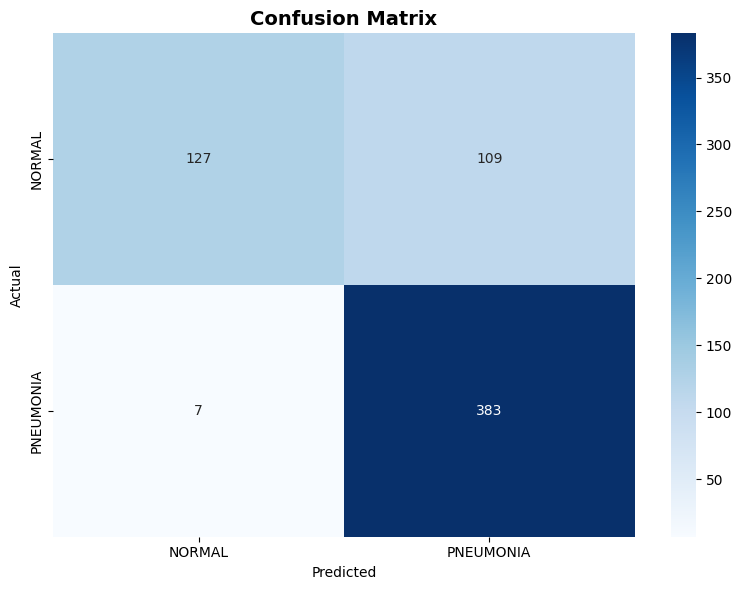

In [24]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### CLASSIFICATION REPORT

In [25]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.95      0.54      0.69       236
   PNEUMONIA       0.78      0.98      0.87       390

    accuracy                           0.81       626
   macro avg       0.86      0.76      0.78       626
weighted avg       0.84      0.81      0.80       626



###  VISUALIZE MISCLASSIFICATIONS

In [34]:
test_generator.reset()
all_images, all_labels = [], []

for i in range(len(test_generator)):
    imgs, lbls = next(test_generator)
    all_images.append(imgs)
    all_labels.append(lbls)

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0).astype(int)

# Get predictions for all images
preds_all = (model.predict(all_images, verbose=0) > 0.5).astype(int).flatten()

# Find misclassified indices
misclassified_idx = np.where(preds_all != all_labels)[0]

print(f"\nTotal misclassified: {len(misclassified_idx)} out of {len(all_labels)}")
print(f"Misclassification rate: {len(misclassified_idx)/len(all_labels)*100:.2f}%")


Total misclassified: 116 out of 626
Misclassification rate: 18.53%


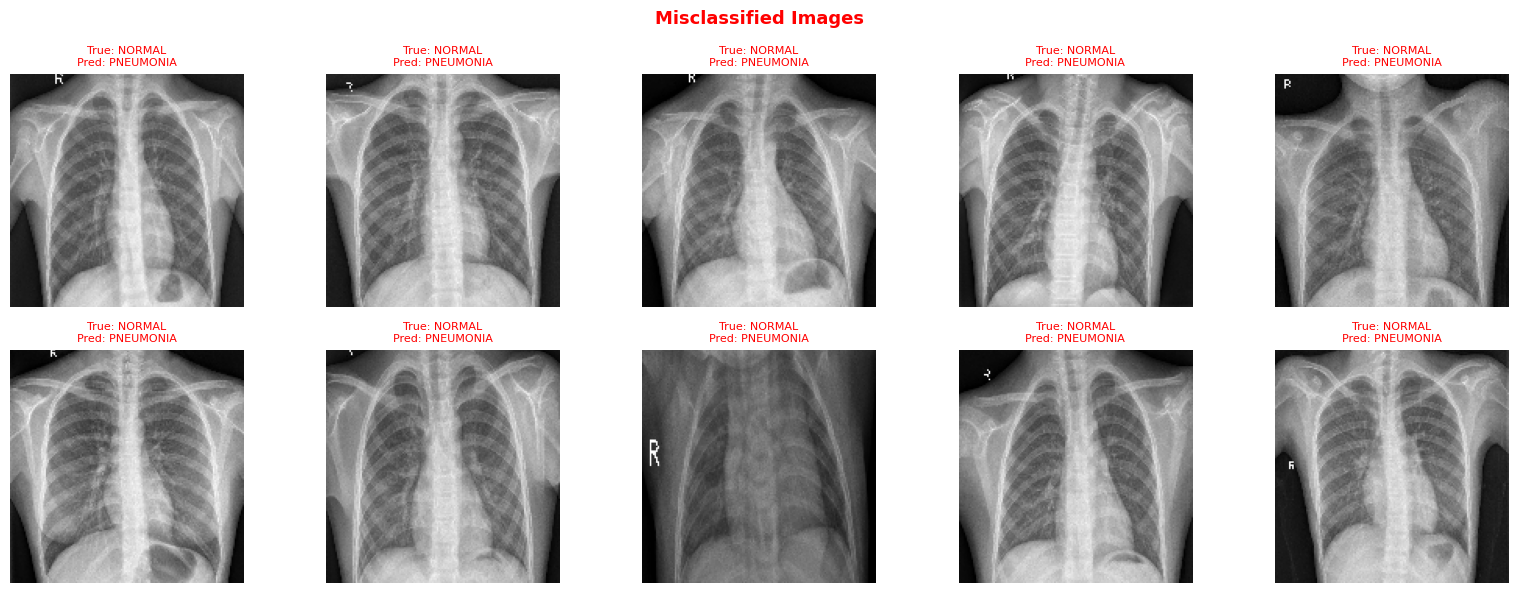

In [32]:

# Plot up to 10 misclassified images
num_show = min(10, len(misclassified_idx))

plt.figure(figsize=(16, 6))
for i in range(num_show):
    idx = misclassified_idx[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(all_images[idx])
    actual    = class_names[all_labels[idx]]
    predicted = class_names[preds_all[idx]]
    plt.title(f'True: {actual}\nPred: {predicted}', color='red', fontsize=8)
    plt.axis('off')
plt.suptitle('Misclassified Images', fontsize=13, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

###  CORRECT PREDICTIONS SAMPLE

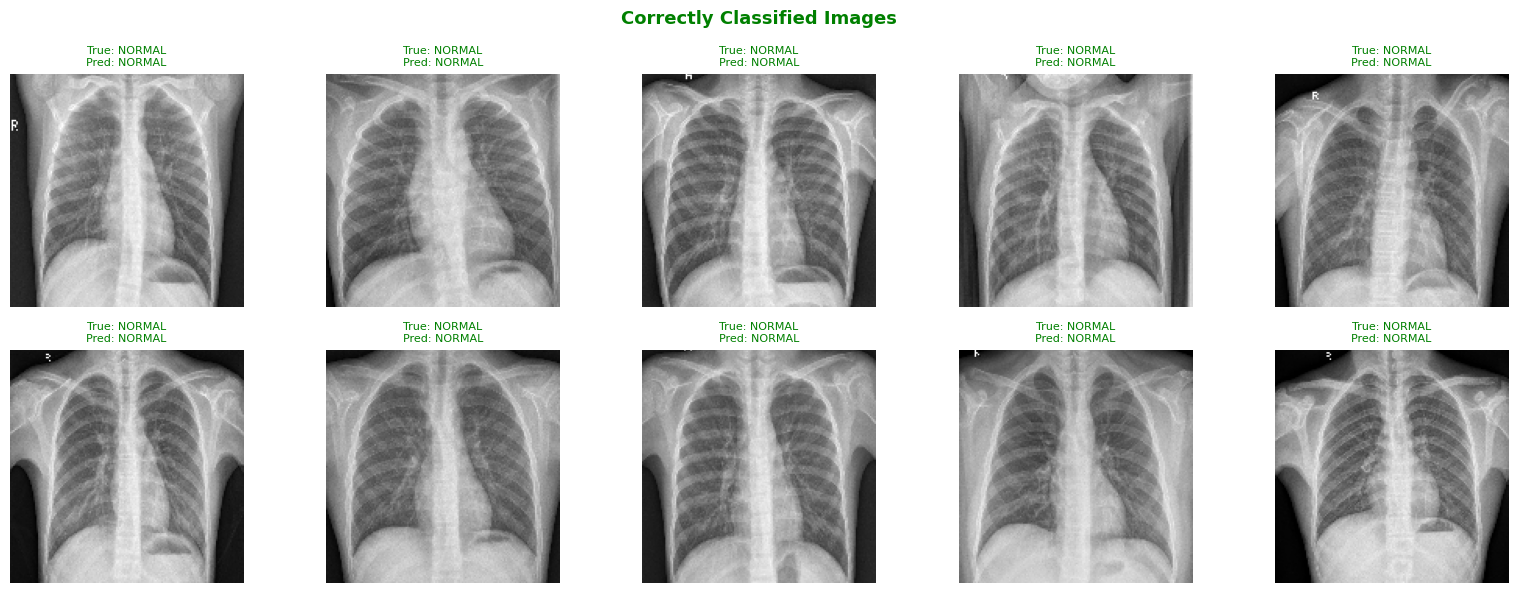

In [28]:
correct_idx = np.where(preds_all == all_labels)[0]
num_show_correct = min(10, len(correct_idx))

plt.figure(figsize=(16, 6))
for i in range(num_show_correct):
    idx = correct_idx[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(all_images[idx])
    actual    = class_names[all_labels[idx]]
    predicted = class_names[preds_all[idx]]
    plt.title(f'True: {actual}\nPred: {predicted}', color='green', fontsize=8)
    plt.axis('off')
plt.suptitle('Correctly Classified Images', fontsize=13, fontweight='bold', color='green')
plt.tight_layout()
plt.show()


### SUMMARY

In [31]:
print(f"\nDataset:")
print(f"  Training images:   {train_generator.samples}")
print(f"  Validation images: {val_generator.samples}")
print(f"  Test images:       {test_generator.samples}")

print(f"\nCNN Architecture:")
print(f"  Input size:        {IMG_HEIGHT}x{IMG_WIDTH}x3")
print(f"  Conv layers:       4")
print(f"  Dense layers:      1 (+ output)")
print(f"  Epochs trained:    {EPOCHS}")

print(f"\nResults:")
print(f"  Test Accuracy:     {test_accuracy:.4f}")
print(f"  Test Loss:         {test_loss:.4f}")
print(f"  Misclassified:     {len(misclassified_idx)} / {len(all_labels)}")


Dataset:
  Training images:   5216
  Validation images: 16
  Test images:       626

CNN Architecture:
  Input size:        150x150x3
  Conv layers:       4
  Dense layers:      1 (+ output)
  Epochs trained:    10

Results:
  Test Accuracy:     0.8147
  Test Loss:         0.4504
  Misclassified:     116 / 626
